### Dimension Reduction Analysis

First run at the combination of embeddings into 2d space for easy visualization. 

* Single dataset (using common API to be easily swapped for any other choice of dataset)
* Group of algorithms
* Analysis of how the algorithms performed vs. each other
    * Visualization of the low dimensional space
    * Comparison via various quality measures
    

In [1]:
import os
from math import ceil

import pandas as pd
import numpy as np

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, Isomap, TSNE
import sklearn.datasets as datasets

from umap import UMAP

import src
from src.visualization.plotting import two_dim_multiplot
import src.quality_measures as qm
import src.embedding_io as e_io
from src.paths import processed_data_path

import logging

LOG_FORMAT = "%(levelname)s %(asctime)s - %(message)s"
DATE_FORMAT = "%m/%d/%Y %I:%M:%S %p"

logging.basicConfig(format=LOG_FORMAT, datefmt=DATE_FORMAT, level=logging.INFO) 
logger = logging.getLogger()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set(style='white', rc={'figure.figsize':(12,8)})

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
## To replace with data from the data directory
## Use small sample of MNIST included in sklearn for the interim

In [5]:
# location to save data to and to where to look for it
if not processed_data_path.exists():
    os.makedirs(processed_data_path)

In [6]:
dataset = datasets.load_digits()
dataset_name = 'Digits'
metric = 'euclidean'

print(dataset.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

In [7]:
high_data = dataset.data
labels = dataset.target

## Choice of algorithms to use

Have them all set to use sklearn style API

* PCA
* MDS
* Isomap
* TSNE
* UMAP

TODO: Include other algorithms that we're going to compare here

In [8]:
low_dimension = 2
random_state = 6502

In [9]:
algorithms = {'PCA' : PCA(n_components=low_dimension, svd_solver='arpack'),
              'MDS' : MDS(n_components=low_dimension, metric=True),
              'tSNE' : TSNE(n_components=low_dimension),
              'Isomap' : Isomap(n_components=low_dimension),
              'UMAP' : UMAP(n_components=low_dimension, metric=metric, random_state=random_state),
             }

The next step takes approximately 
* Digits: 2 minutes
* COIL-20: 8 minutes

In [10]:
low_data = {}
metadata = {}
for name, algorithm in algorithms.items():
    logger.info(f"Starting {name}")
    basefilename = "_".join([name, dataset_name.replace(' ', '-')])
    low_data[name], _, metadata[name] = e_io.create_embedding(basefilename, data=high_data, 
                                                              algorithm_object=algorithms[name], 
                                                              labels=labels, algorithm_name=name,
                                                              dataset_name=dataset_name,
                                                              data_path=processed_data_path)

INFO 07/04/2018 05:20:10 PM - Starting PCA
INFO 07/04/2018 05:20:10 PM - No existing metadata file found. Creating from scratch.
INFO 07/04/2018 05:20:10 PM - PROCESS_TIME:                                 PCA    38.6 ms
INFO 07/04/2018 05:20:10 PM - Reading embedding PCA_Digits_0.embedding.npy
INFO 07/04/2018 05:20:10 PM - Starting MDS
INFO 07/04/2018 05:20:10 PM - No existing metadata file found. Creating from scratch.
INFO 07/04/2018 05:21:43 PM - PROCESS_TIME:                                 MDS    93.2 s
INFO 07/04/2018 05:21:43 PM - Reading embedding MDS_Digits_0.embedding.npy
INFO 07/04/2018 05:21:43 PM - Starting tSNE
INFO 07/04/2018 05:21:43 PM - No existing metadata file found. Creating from scratch.
INFO 07/04/2018 05:22:17 PM - PROCESS_TIME:                                tSNE    33.7 s
INFO 07/04/2018 05:22:17 PM - Reading embedding tSNE_Digits_0.embedding.npy
INFO 07/04/2018 05:22:17 PM - Starting Isomap
INFO 07/04/2018 05:22:17 PM - No existing metadata file found. Creati

## Visualization of the Embeddings

In [11]:
data = []
labels_list = [labels] * len(low_data)
titles = []

for k, v in low_data.items():
    data.append(v)
    titles.append(k)

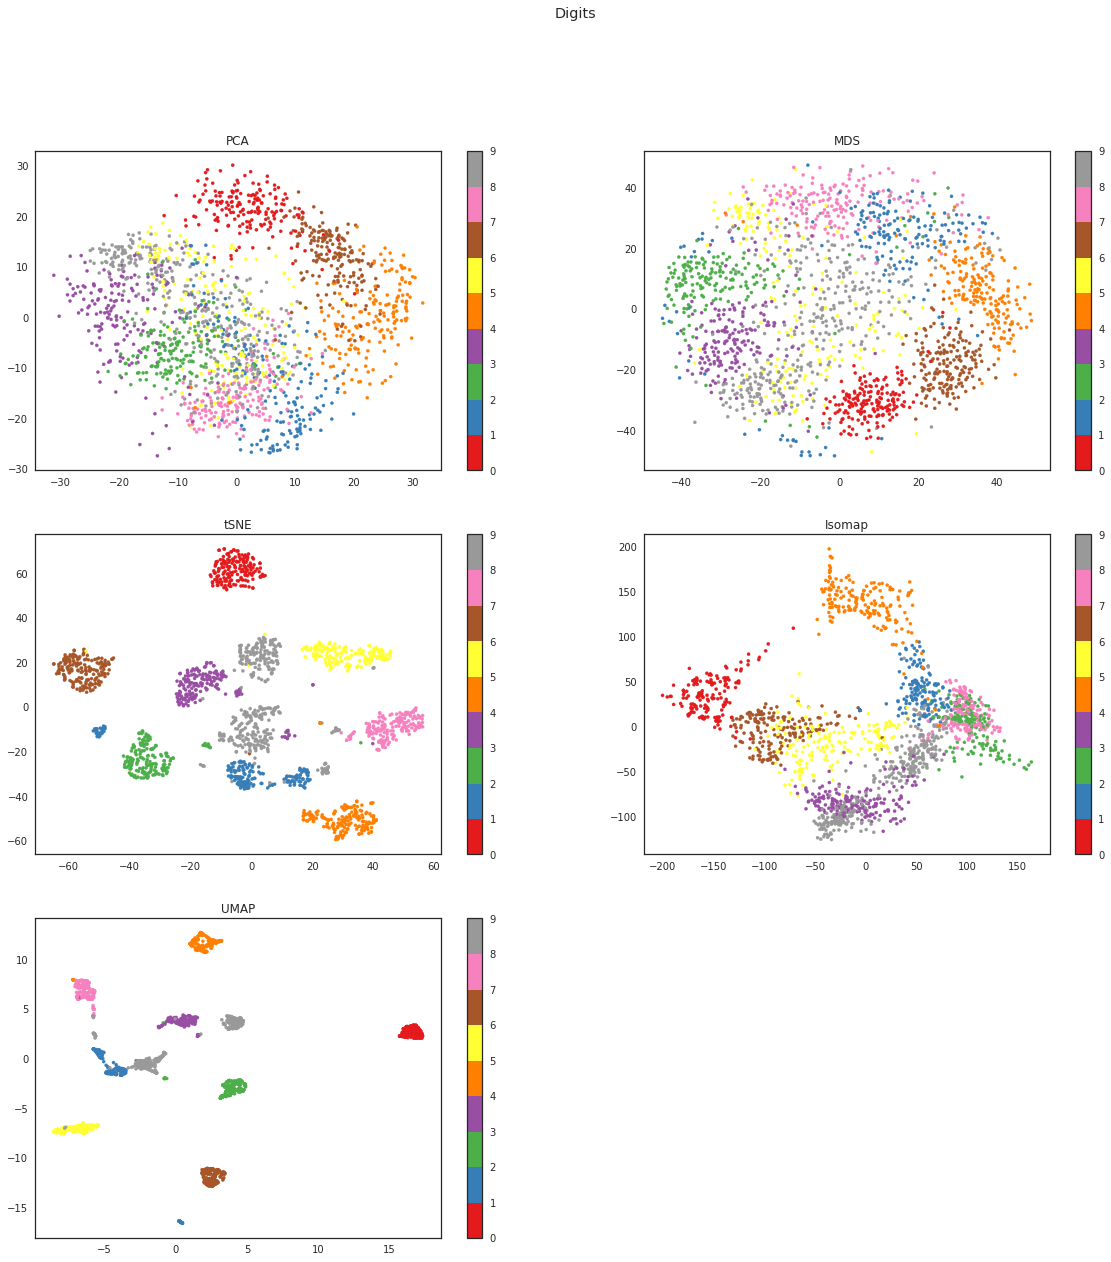

In [12]:
sns.set(style='white', rc={'figure.figsize':(20,20)})
two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="Set1", s=10, share_cbar=False)
plt.suptitle(dataset_name);

## Analysis via quality scores

Start by getting pairwise distances needed for both Stress and Strain.

In [13]:
high_distances = pairwise_distances(high_data, metric=metric)

In [14]:
%%time
low_distances_dict = {}
for name, data in low_data.items():
    _, low_distances, _ = qm.pairwise_distance_differences(high_distances=high_distances,
                                                           low_data=data, metric=metric)
    low_distances_dict[name] = low_distances

CPU times: user 302 ms, sys: 572 ms, total: 874 ms
Wall time: 273 ms


### Strain from Classical MDS
Strain is the name given to stress that is optimized in classical MDS. The optimal solution is given by PCA.

$$\textstyle Strain_{D}(x_{1},x_{2},...,x_{N})={\Biggl (}{\frac {\sum _{i,j}{\bigl (}b_{ij}-\langle x_{i},x_{j}\rangle {\bigr )}^{2}}{\sum _{i,j}b_{ij}^{2}}}{\Biggr )}^{1/2}$$

where $B = -\frac{1}{2} J D^{(2)}J$ and $J = I_{N}-{\tfrac  {1}{N}}{\mathbf  {1}}{\mathbf  {1}}^{\top }$ where $\mathbf  {1}$ is the $N$-dimensional vector of 1's. 

#### Note: Only need to change the following to cells to get the analysis using a different quality score

In [15]:
score = 'Strain'

In [16]:
%%time
point_score = {}
total_score = {}
for name, low_distances in low_distances_dict.items():
    point_score[name] = qm.point_strain(high_distances=high_distances, 
                                          low_distances=low_distances,
                                          metric=metric)
    total_score[name] = qm.strain(high_distances=high_distances, 
                                          low_distances=low_distances,
                                          metric=metric)

CPU times: user 10.8 s, sys: 4.34 s, total: 15.2 s
Wall time: 4.07 s


### Visualization of the point score on the same scale
Color represents the value of the contribution of a given point towards the total score

In [17]:
data = []
labels_list = []
titles = []

for k, v in low_data.items():
    data.append(v)
    titles.append(f"{k}\n {score}: {total_score[k]}")
    labels_list.append(point_score[k])

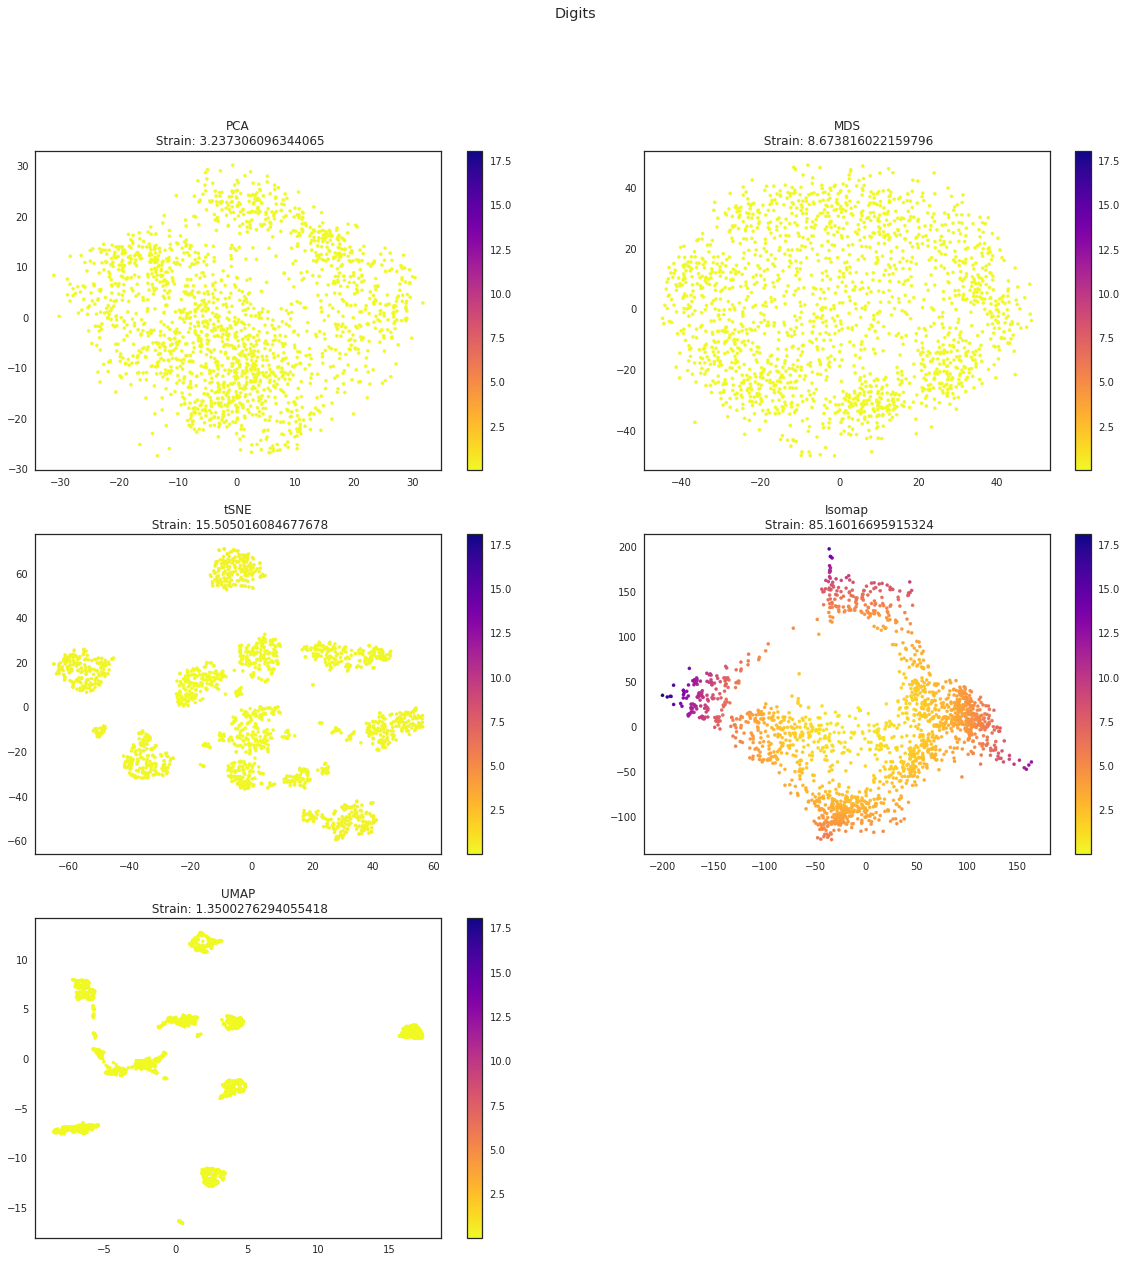

In [18]:
sns.set(style='white', rc={'figure.figsize':(20,20)})

two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="plasma_r", s=10, share_cbar=True)
plt.suptitle(dataset_name);

### How about distributions

In [19]:
point_score_df = pd.DataFrame(point_score)

In [20]:
point_score_df.describe()

,PCA,MDS,tSNE,Isomap,UMAP
count,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.005832,0.041867,0.133782,4.035756,0.001014
std,0.003238,0.019170,0.085227,2.613873,0.000403
min,0.001103,0.007791,0.027568,0.809529,0.000243
25%,0.003168,0.027655,0.057987,2.246928,0.000730
50%,0.005374,0.041399,0.109179,3.396886,0.000992
75%,0.007855,0.055259,0.199960,4.900101,0.001257
max,0.018806,0.106921,0.359408,18.053235,0.002214


/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg

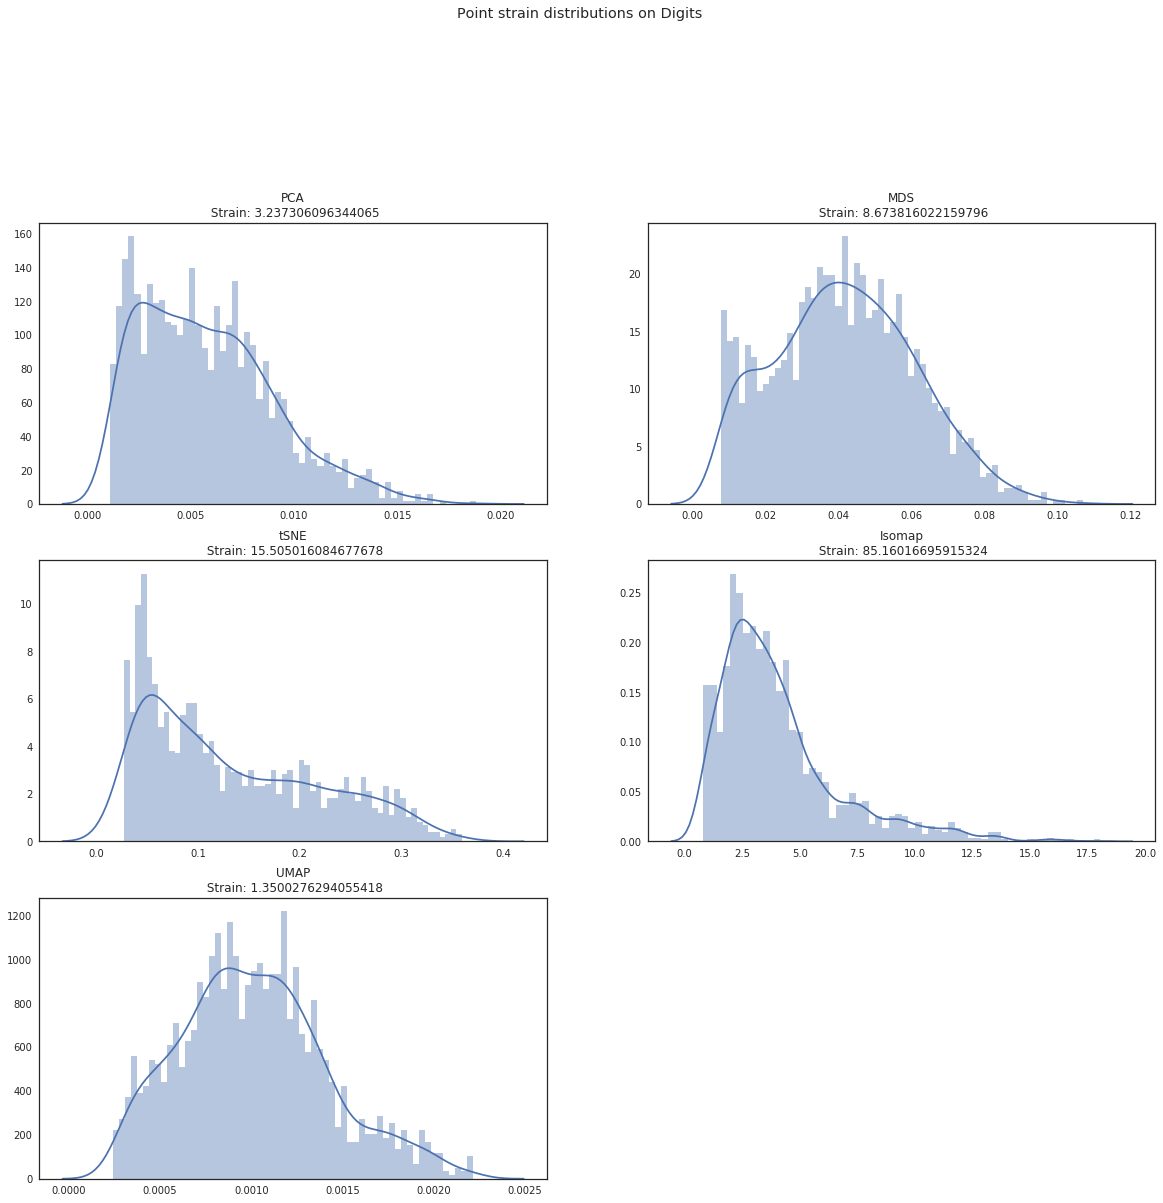

In [21]:
sns.set(style='white', rc={'figure.figsize':(20,30)})

plot_num = 1
ncols = 2
nrows = ceil(len(point_score))

for name, p_score in point_score.items():
    plt.subplot(nrows, ncols, plot_num)
    plot_num += 1
    plt.title(f"{name}\n {score}: {total_score[name]}")
    sns.distplot(p_score, bins=60)
plt.suptitle(f"Point {score.lower()} distributions on {dataset_name}");

### With different colorbar scales

Here we can see where the distrubutions lie with respect to the reduction

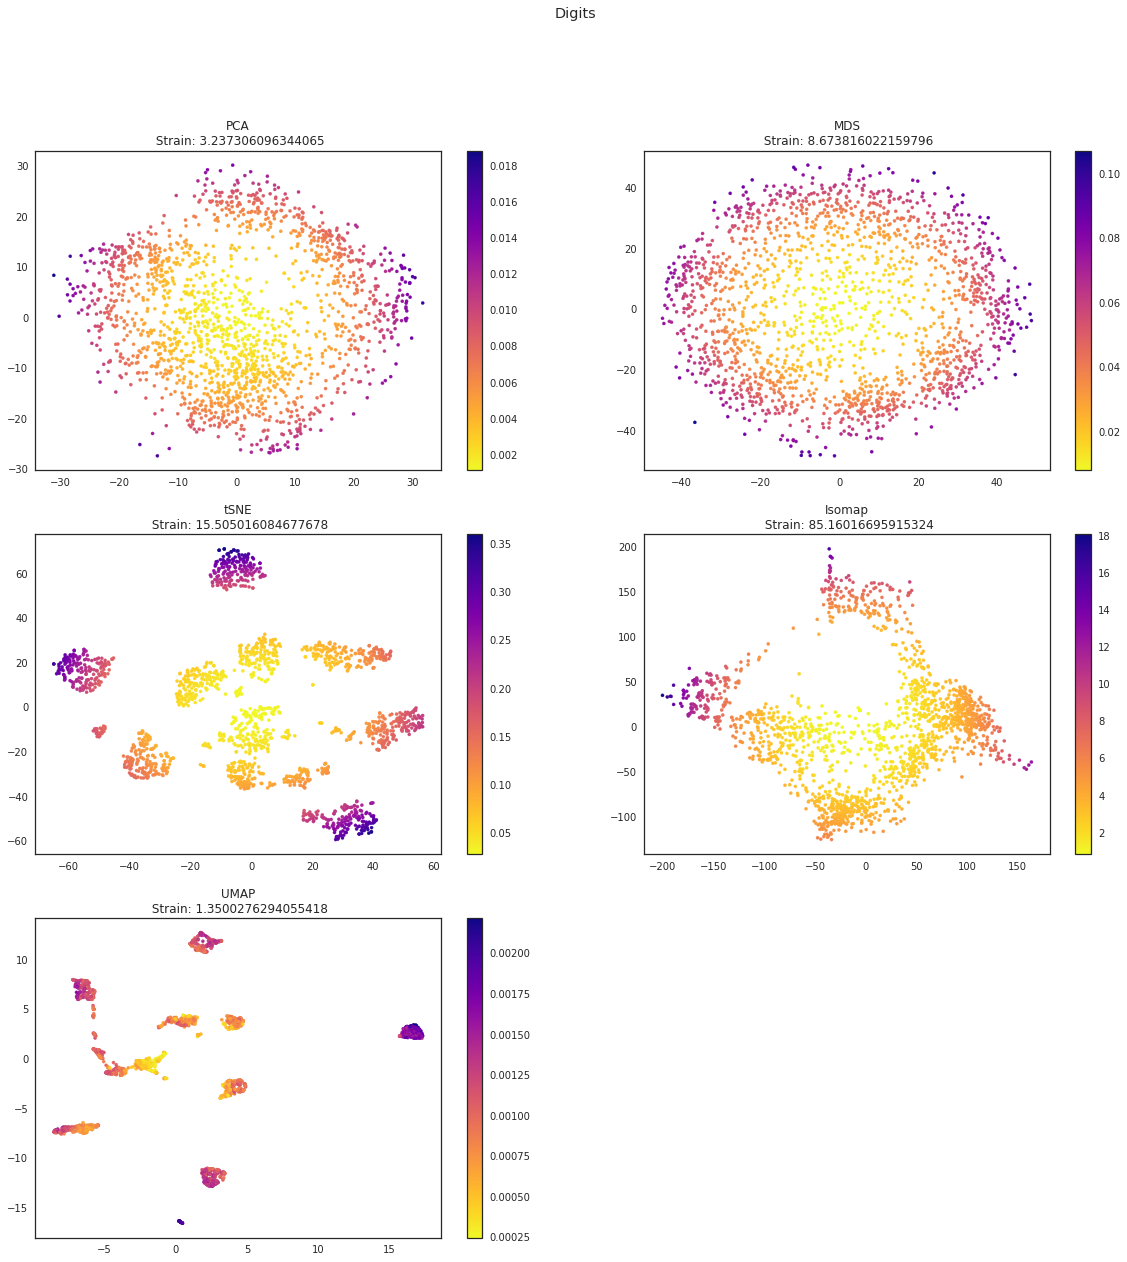

In [22]:
sns.set(style='white', rc={'figure.figsize':(20,20)})

two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="plasma_r", s=10, share_cbar=False)
plt.suptitle(dataset_name);

## Are the same points contributing to the high values in all cases?

In [23]:
n_worst_points = 100

In [24]:
worst_scoring_points = {}
for name, p_score in point_score.items():
    a = point_score_df[name]
    worst_scoring_points[name] = np.argpartition(a, -1 * n_worst_points)[-1 * n_worst_points:]

In [25]:
shared_points_idx = set(point_score_df.index)
for name, worst_points in worst_scoring_points.items():
    shared_points_idx.intersection_update(worst_points)
shared_points_idx = list(shared_points_idx)
len(shared_points_idx)

0

In [26]:
point_score_df.iloc[shared_points_idx]

,PCA,MDS,tSNE,Isomap,UMAP


In [27]:
# Note that there is overlap if we take stress instead of strain with COIL-20